In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
import os

GROUND_TRUTH_PATH = '/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv'
IMAGE_DIR ='/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_DEPTH = 3

BATCH_SIZE = 32

Using TensorFlow backend.


In [2]:
def read_split_data(gt_path=GROUND_TRUTH_PATH, rn_seed=42):
    np.random.seed(rn_seed)
    gt = pd.read_csv(gt_path)
    gt.drop(['UNK'], axis=1, inplace=True)
    for ind in range(len(gt)):
        gt.image[ind] += '.jpg'
    val_inds = (np.random.rand(len(gt)//5) * len(gt)).astype(int)
    tr_gt = gt.drop(val_inds, axis=0)
    va_gt = gt.iloc[val_inds]
    return gt, tr_gt, va_gt 


ground_truth, train_gt, valid_gt = read_split_data()
labels = list(ground_truth.columns[1:])
labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

In [3]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19

def get_image_gen(df, x_col, y_cols, batch_size=BATCH_SIZE, im_dir=IMAGE_DIR, im_width=IMAGE_WIDTH, im_height=IMAGE_HEIGHT, rn_seed=42, data_aug=False, class_mode="raw"):
    if data_aug:
        image_generator = ImageDataGenerator(horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             preprocessing_function=preprocess_input)  # uses VGG preprocessing
    else:
        image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  # uses VGG preprocessing
        
    gen = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=im_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode=class_mode,
        batch_size=batch_size,
        shuffle=True,
        seed=rn_seed,
        target_size=(im_width, im_height))
    
    return gen


train_gen = get_image_gen(train_gt, 'image', labels, data_aug=True)
valid_gen = get_image_gen(valid_gt, 'image', labels)

Found 20763 validated image filenames.
Found 5066 validated image filenames.


(32, 224, 224, 3)
(32, 8)


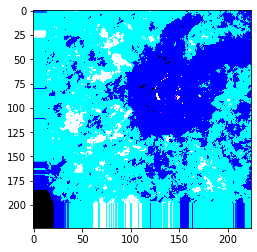

In [4]:
x, y = train_gen.__getitem__(0)
print(x.shape)
print(y.shape)
plt.imshow(x[0])

**Weighted Loss Function**

In [5]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    return weighted_loss


neg_weights = np.mean(train_gen.labels, axis=0)
pos_weights = 1 - neg_weights

**Focal Loss Function**

In [6]:
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """
            Source: https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -K.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [7]:
def get_vgg_model(labels, loss='binary_crossentropy', trainable=True, im_width=IMAGE_WIDTH, im_height=IMAGE_HEIGHT, im_depth=IMAGE_DEPTH):
    model = Sequential()
    model.add(VGG19(weights='imagenet', include_top=False, input_shape=(im_width, im_height, im_depth)))
    
    for layer in model.layers:
        layer.trainable = trainable
    
    # last few layers: https://www.kaggle.com/awsaf49/isic-2019-beginner
    model.add(GlobalAveragePooling2D())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(labels), activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=loss, metrics=['accuracy'])
    return model

# define loss function
# model_loss = focal_loss()
# create and compile model
model = get_vgg_model(labels)
model.summary()

80142336/80134624 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________

**Fit, Save, and Evaluate Model**

In [8]:
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen,
                              steps_per_epoch=train_gen.samples//BATCH_SIZE, 
                              validation_steps=valid_gen.samples//BATCH_SIZE, 
                              epochs=5)

Train for 648 steps, validate for 158 steps
Epoch 1/5
648/648 [==============================] - 1543s 2s/step - loss: 0.3143 - accuracy: 0.8752 - val_loss: 0.2562 - val_accuracy: 0.8922
Epoch 2/5
648/648 [==============================] - 1257s 2s/step - loss: 0.2338 - accuracy: 0.9102 - val_loss: 0.2291 - val_accuracy: 0.9086
Epoch 3/5
648/648 [==============================] - 1220s 2s/step - loss: 0.2212 - accuracy: 0.9144 - val_loss: 0.2045 - val_accuracy: 0.9186
Epoch 4/5
648/648 [==============================] - 1219s 2s/step - loss: 0.2151 - accuracy: 0.9163 - val_loss: 0.2103 - val_accuracy: 0.9193
Epoch 5/5
648/648 [==============================] - 1223s 2s/step - loss: 0.2100 - accuracy: 0.9186 - val_loss: 0.2026 - val_accuracy: 0.9230


In [9]:
model.save("vgg19_5_epoch.h5")

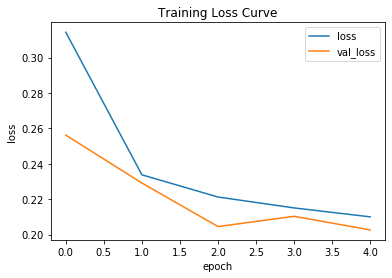

In [10]:
# Loss Plots for train and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.legend(['loss','val_loss'])
plt.show()

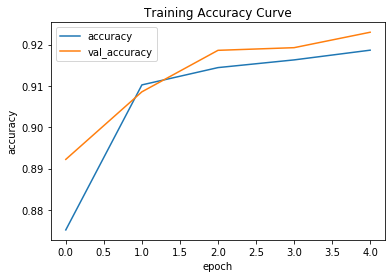

In [11]:
# Accuracy Plots for train and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Accuracy Curve")
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [12]:
# predictions
predicted_vals = model.predict_generator(valid_gen, steps=valid_gen.samples)

In [13]:
"""
TODO: plot confusion matrix using seaborn
"""

# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# conf_mat = confusion_matrix(, predicted)
# df_cm = pd.DataFrame(array, index = [i for i in labels],
#                   columns = [i for i in labels])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

'\nTODO: plot confusion matrix using seaborn\n'

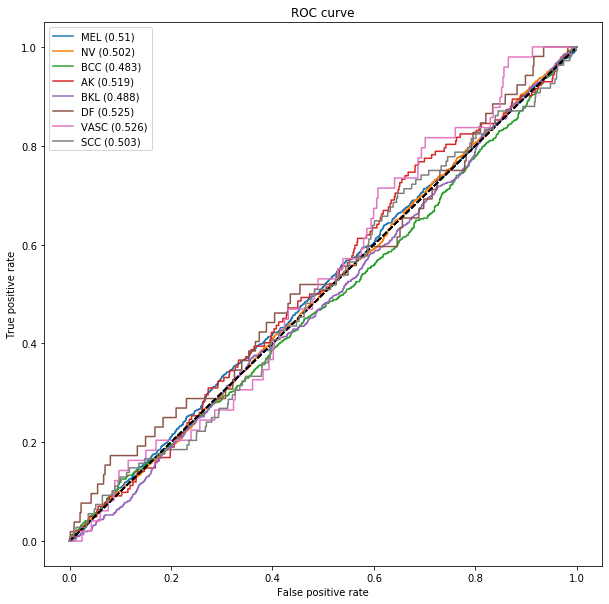

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


auc_rocs = get_roc_curve(labels, predicted_vals, valid_gen)